The focus here is on the Full CDKMRippleCarryAdder, as the QFT Adder is redundant (we have another notebook for QFT).

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import CDKMRippleCarryAdder

a = 1
b = 3

def cut_ripple_carry_adder(a, b):
    n_qubits = max(a.bit_length(), b.bit_length())
    operand1 = QuantumRegister(n_qubits, 'o1')
    operand2 = QuantumRegister(n_qubits, 'o2')
    anc = QuantumRegister(2, 'a')
    cr = ClassicalRegister(n_qubits + 1)
    qc = QuantumCircuit(operand1, operand2, anc, cr)
    for i in range(n_qubits):
        if (a & (1 << i)):
            qc.x(operand1[i])
        if (b & (1 << i)):
            qc.x(operand2[i])
    adder = CDKMRippleCarryAdder(n_qubits, 'full', 'Full Adder')
    qc.append(adder, [anc[0]] + operand1[:] + operand2[:] + [anc[1]])
    qc.measure(operand2[:] + [anc[1]], cr)

    simulator = AerSimulator()
    qc = transpile(qc, simulator)

    # Run and get counts
    result = simulator.run(qc).result()
    counts = result.get_counts(qc)
    return counts, qc


counts, qc = cut_ripple_carry_adder(a, b)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [4]:
counts

{'100': 1024}

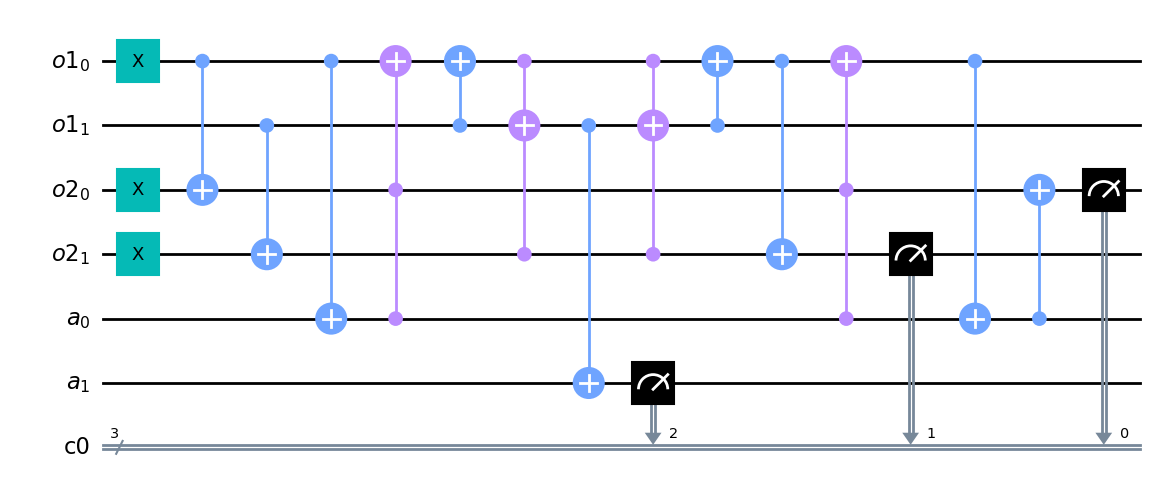

In [8]:
qc.draw('mpl')

We need to decompose the circuit to remove the CCX gates:

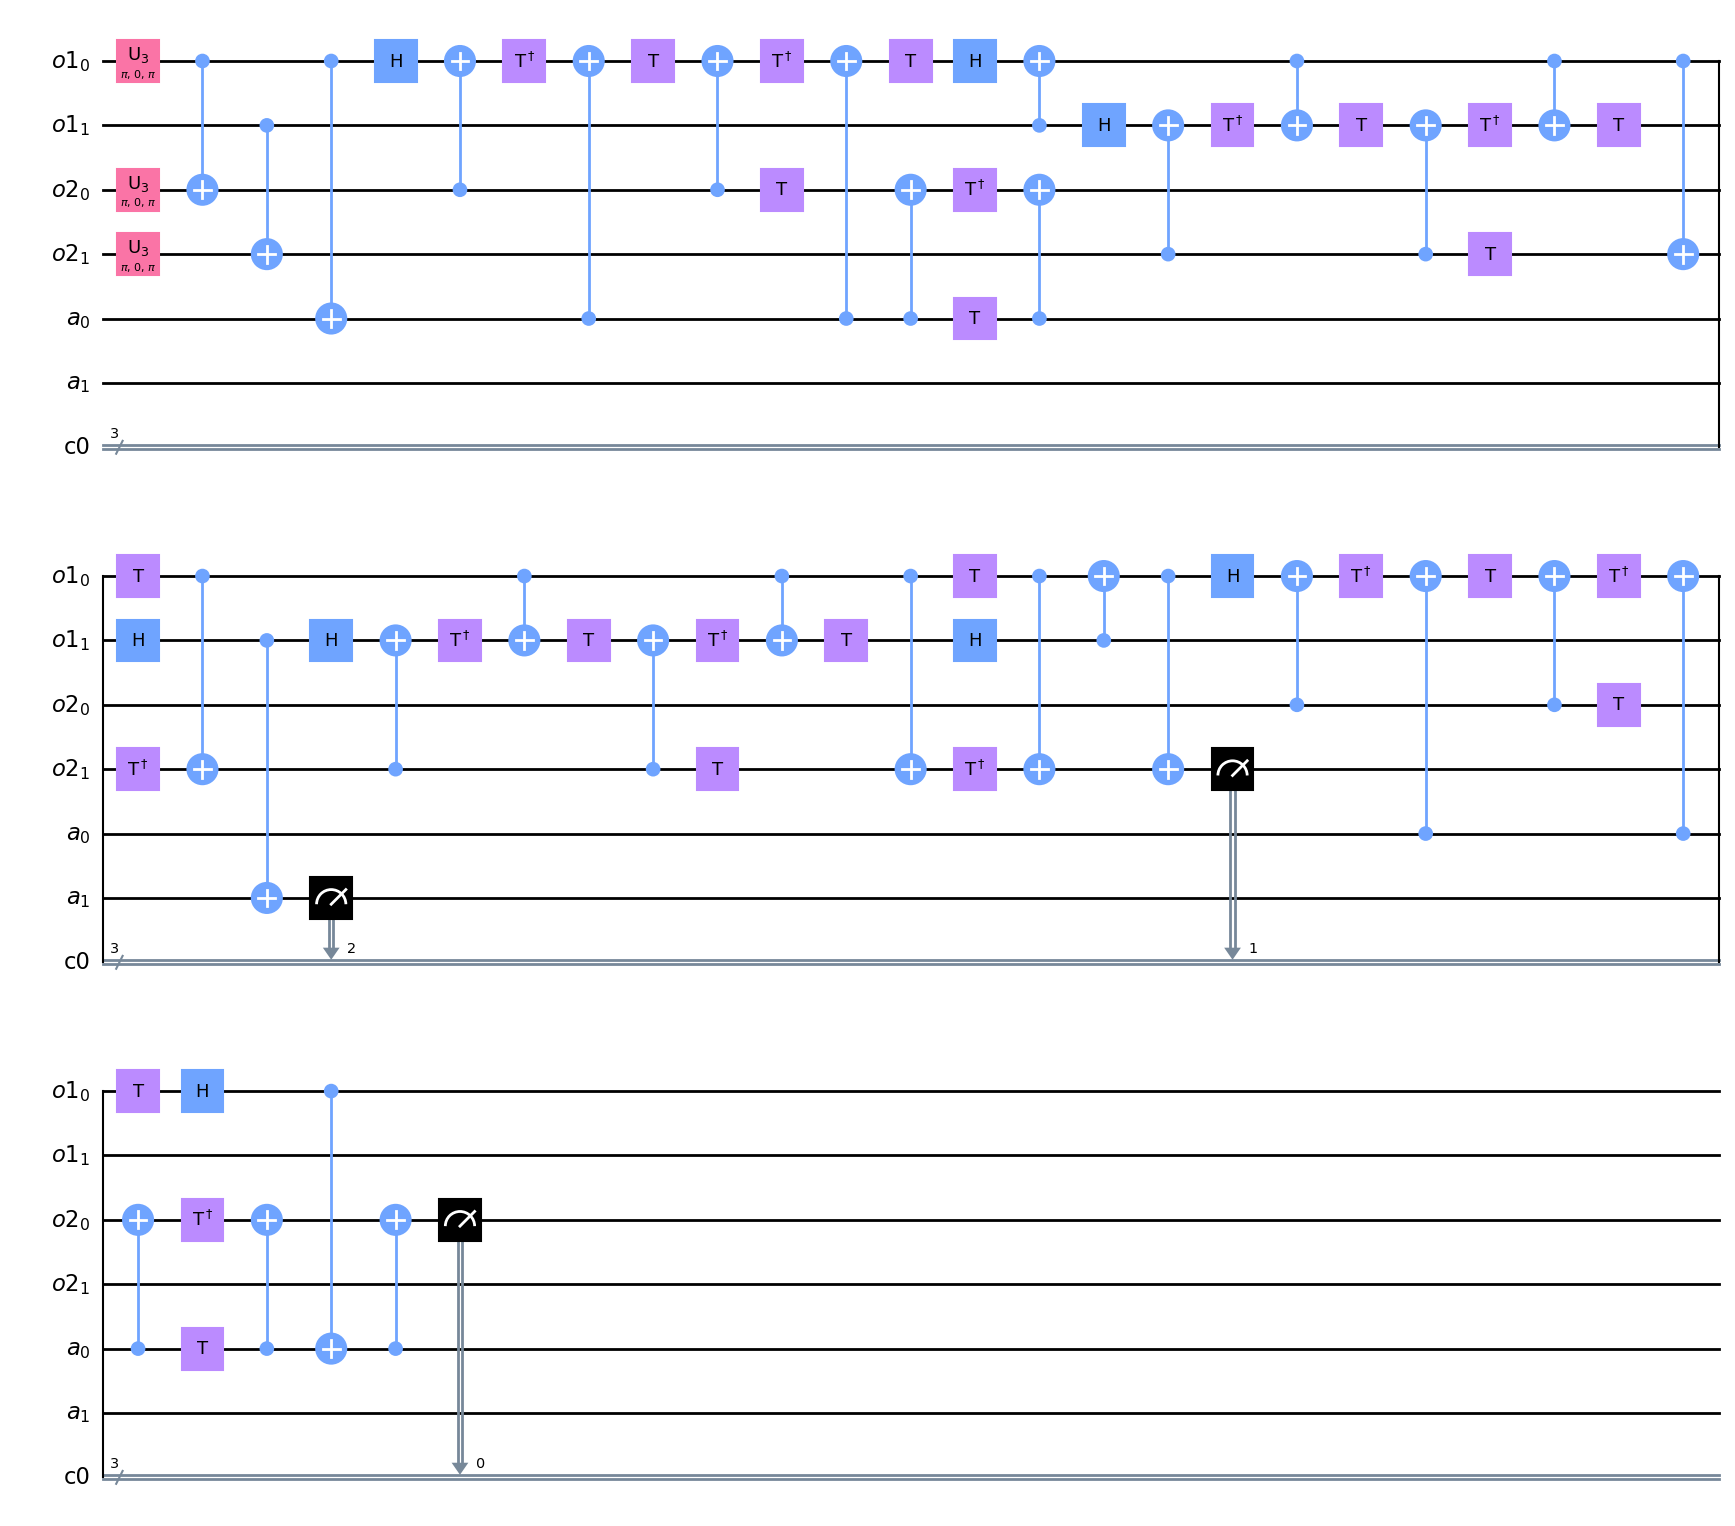

In [7]:
qc.decompose().draw('mpl')

We will also need to remove our classical register, so let's define our circuit from scratch without it...

In [12]:
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import cut_wires_and_gates_to_subcircuits
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import execute_simulation
from circuit_knitting.cutting.cutting_reconstruction import reconstruct_expectation_values
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import exact_observables
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import compare_results

In [30]:
a = 1
b = 1

def cut_ripple_carry_adder_no_cr(a, b):
    n_qubits = max(a.bit_length(), b.bit_length())
    operand1 = QuantumRegister(n_qubits, 'o1')
    operand2 = QuantumRegister(n_qubits, 'o2')
    anc = QuantumRegister(2, 'a')
    qc = QuantumCircuit(operand1, operand2, anc)
    for i in range(n_qubits):
        if (a & (1 << i)):
            qc.x(operand1[i])
        if (b & (1 << i)):
            qc.x(operand2[i])
    adder = CDKMRippleCarryAdder(n_qubits, 'full', 'Full Adder')
    qc.append(adder, [anc[0]] + operand1[:] + operand2[:] + [anc[1]])
    #qc.measure(operand2[:] + [anc[1]], cr)

    return qc

circuit = cut_ripple_carry_adder_no_cr(a, b)


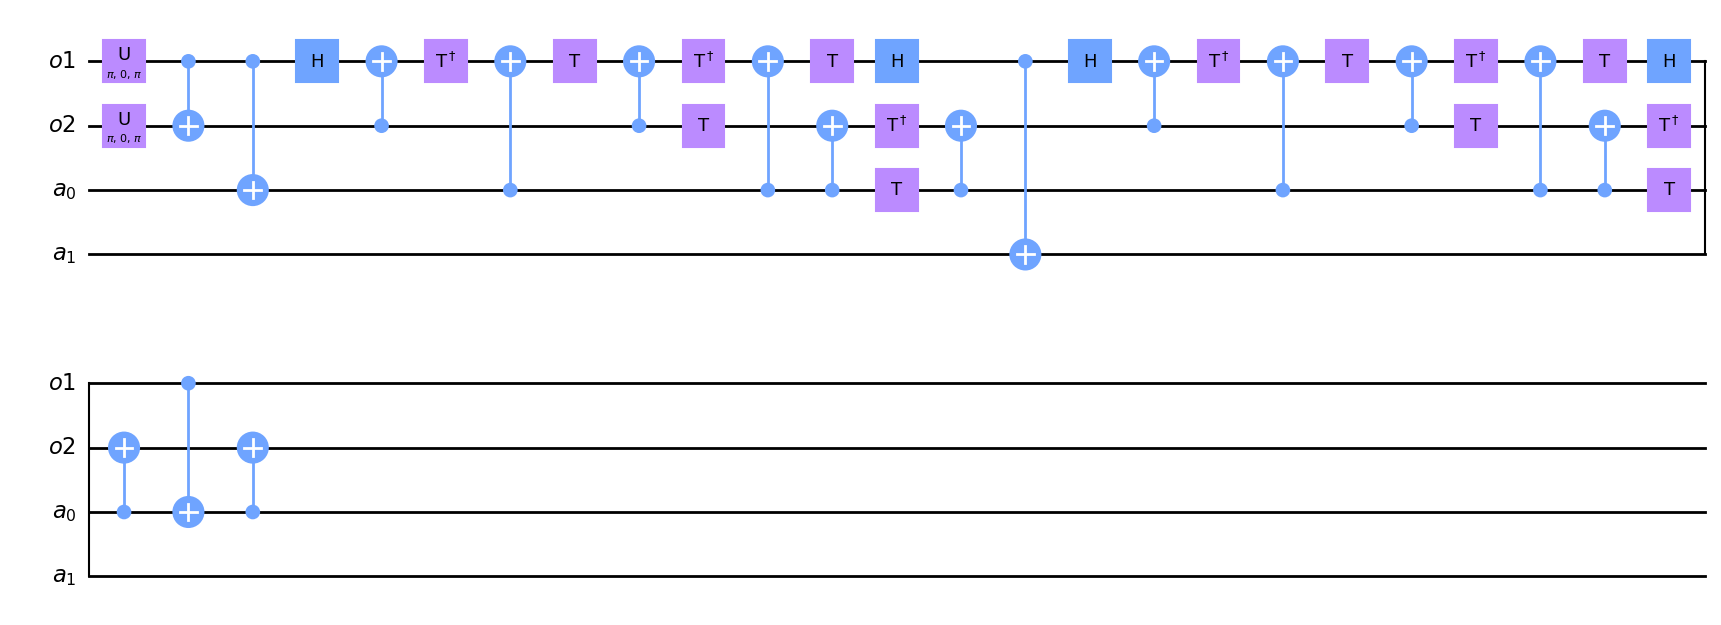

In [31]:
circuit = circuit.decompose(reps=4)
circuit.draw('mpl')

In [32]:
observables = ['Z'*qc_dec.num_qubits]

In [33]:
subcircuits, subobservables = cut_wires_and_gates_to_subcircuits(
    circuit=circuit,
    observables=observables,
    method='automatic',
    max_subcircuit_width=3,
    max_cuts=4,
    num_subcircuits=[2],
    model='gurobi'
)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 443 rows, 185 columns and 1514 nonzeros
Model fingerprint: 0x4318fb75
Variable types: 0 continuous, 185 integer (170 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 65 rows and 51 columns
Presolve time: 0.00s
Presolved: 378 rows, 134 columns, 1239 nonzeros
Variable types: 0 continuous, 134 integer (128 binary)
Found heuristic solution: objective 4.0000000

Root relaxation: objective 1.000000e+00, 85 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unex

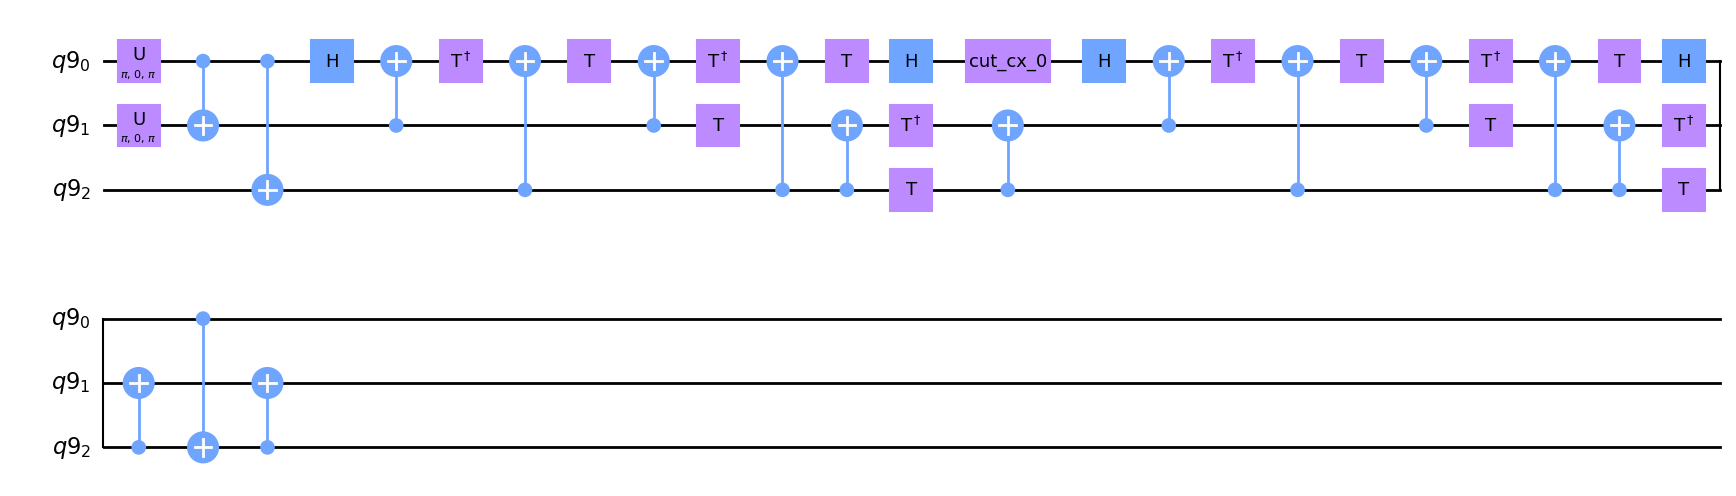

In [34]:
subcircuits[0].draw('mpl')

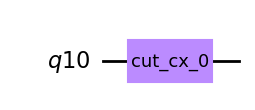

In [35]:
subcircuits[1].draw('mpl')

The cutter fails for a V b > 1 as the circuit depth becomes unmanageable by the gurobi solver, and even for a,b=1 we have a trivial and unhelpful cut.